### Setup

In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from src.lstm import LSTM
from src.trainer import Trainer, EarlyStopping
from data.data_creation import get_trajectories, plot_trajectories
from data_creation import plot_boxplots

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def load_data():
    if not os.path.exists('data/trajectories.npy'):
        sol = get_trajectories()  # x,y,vx,vy,t
        pickle.dump(sol, open('data/trajectories.npy', 'wb'))
    else:
        sol = np.load('data/trajectories.npy', allow_pickle=True)
    return sol
    
def data_preperation(sol, train_test_split=0.85): 
    x,y,vx,vy,t = sol

    data = np.vstack((x, y, vx, vy)).T
    
    print(data.dtype)
    print(f"Data shape: {data.shape}")
    
    train_end = int(train_test_split * len(data))
    
    train_data = data[:train_end]
    test_data = data[train_end:]
    print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}")

    return train_data, test_data


def generate_xy(data, lag=1, history=False):
    n = len(data)
    if history > lag:
        raise ValueError("History cannot be greater than lag.")
    if history:
        X = torch.stack([torch.flatten(torch.tensor(data[i:i+history])) for i in range(n - lag)])
    else:
        X = torch.stack([torch.tensor(X[i]) for i in range(n - lag)])
    y = torch.tensor(data[lag:])
    print(y.shape)
    # change y to only the x, y positions so first 6 columns
    # y = y[:, :6]
    return X, y


def normalize_data(train_data, test_data, scaler=None):
    if scaler is None:
        #scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = RobustScaler()
    scaler.fit(train_data)
    normalized_train_data = scaler.transform(train_data)
    normalized_test_data = scaler.transform(test_data)
    return normalized_train_data, normalized_test_data, scaler

def save_model(model, path='models/model', i=0):
    # check if model directory exists
    dir_name = os.path.dirname(path+i+'.pt')
    try:
        if not os.path.exists(dir_name):
            torch.save(model.state_dict(), path)
            return f'Model saved successfully at path {dir_name}.'
        else:
            return save_model(model, path, i+1)
    except RecursionError:
        return 'Failed to save model after multiple attempts.'


### Train stateful models

In [3]:
sol = load_data()
train_data, test_data = data_preperation(sol, train_test_split=0.85)

lag = 10
train_data, test_data, scaler = normalize_data(train_data, test_data)

def generate_xy(data, lag=lag):
    X = torch.tensor(data[:-lag], dtype=torch.float32)
    y = torch.tensor(data[lag:], dtype=torch.float32)
    return X, y

X_train, y_train = generate_xy(train_data, lag)
X_test, y_test = generate_xy(test_data, lag)

float64
Data shape: (100000, 12)
Train data shape: (85000, 12)
Test data shape: (15000, 12)



--- Training LSTM with hidden size 256 ---
Epoch 1/100, Training Loss: 0.868489
Epoch 1/100, Validation Loss: 0.556630
Epoch 2/100, Training Loss: 0.658718
Epoch 2/100, Validation Loss: 0.419027
Epoch 3/100, Training Loss: 0.486879
Epoch 3/100, Validation Loss: 0.308060
Epoch 4/100, Training Loss: 0.349232
Epoch 4/100, Validation Loss: 0.221683
Epoch 5/100, Training Loss: 0.243242
Epoch 5/100, Validation Loss: 0.157744
Epoch 6/100, Training Loss: 0.166788
Epoch 6/100, Validation Loss: 0.113300
Epoch 7/100, Training Loss: 0.117121
Epoch 7/100, Validation Loss: 0.084422
Epoch 8/100, Training Loss: 0.089871
Epoch 8/100, Validation Loss: 0.066743
Epoch 9/100, Training Loss: 0.078819
Epoch 9/100, Validation Loss: 0.056449
Epoch 10/100, Training Loss: 0.077047
Epoch 10/100, Validation Loss: 0.050803
Epoch 11/100, Training Loss: 0.078722
Epoch 11/100, Validation Loss: 0.047907
Epoch 12/100, Training Loss: 0.080093
Epoch 12/100, Validation Loss: 0.046314
Epoch 13/100, Training Loss: 0.079500


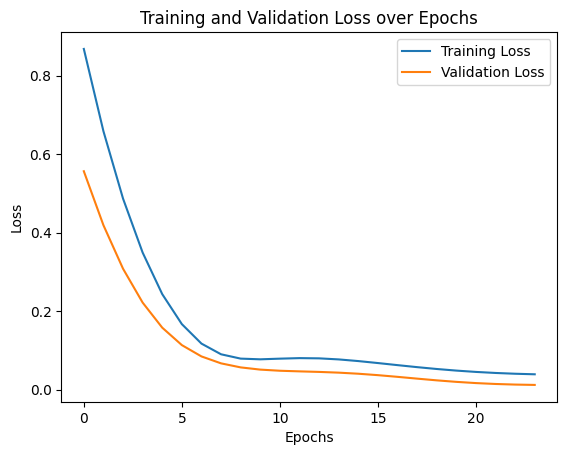

Saved model and losses for hidden size 256

--- Training LSTM with hidden size 512 ---
Epoch 1/100, Training Loss: 0.739782
Epoch 1/100, Validation Loss: 0.302485
Epoch 2/100, Training Loss: 0.310890
Epoch 2/100, Validation Loss: 0.094349
Epoch 3/100, Training Loss: 0.107411
Epoch 3/100, Validation Loss: 0.051908
Epoch 4/100, Training Loss: 0.074311
Epoch 4/100, Validation Loss: 0.078819
Early stopping


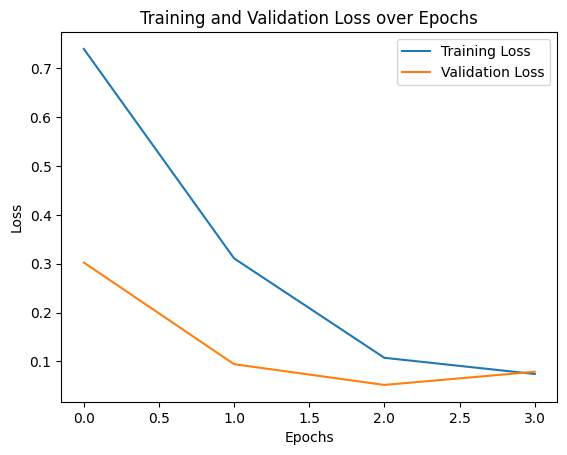

Saved model and losses for hidden size 512

--- Training LSTM with hidden size 1024 ---
Epoch 1/100, Training Loss: 1.001339
Epoch 1/100, Validation Loss: 0.086912
Epoch 2/100, Training Loss: 0.097895
Epoch 2/100, Validation Loss: 0.171718
Early stopping


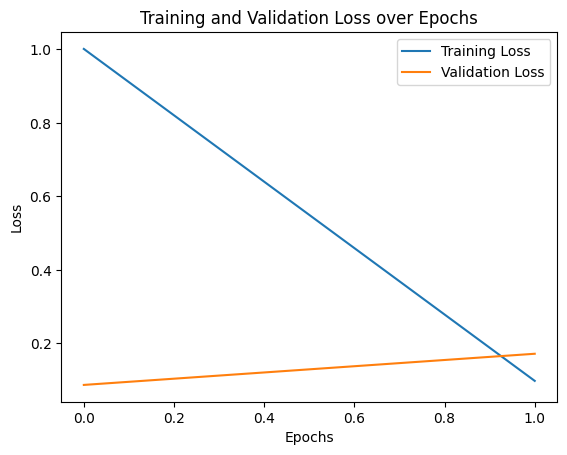

Saved model and losses for hidden size 1024


In [ ]:
hidden_sizes = [256, 512, 1024]  # adjust as needed
num_epochs = 100

os.makedirs("stateful_models", exist_ok=True)

for hidden_size in hidden_sizes:
    print(f"\n--- Training LSTM with hidden size {hidden_size} ---")
    model = LSTM(input_size=12, hidden_size=hidden_size, output_size=12, initializer_method='xavier').to(device)
    early_stopping = EarlyStopping(patience=1)
    trainer = Trainer(model, learning_rate=0.001, early_stopping=early_stopping)
    
    trainer.train(X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device), epochs=num_epochs)

    trainer.plot_losses()
    
    # Save model and training history
    model_path = f"stateful_models/lstm_stateful_h{hidden_size}.pt"
    torch.save(model.state_dict(), model_path)
    np.save(f"stateful_models/train_losses_h{hidden_size}.npy", np.array(trainer.train_losses))
    np.save(f"stateful_models/val_losses_h{hidden_size}.npy", np.array(trainer.val_losses))
    
    print(f"Saved model and losses for hidden size {hidden_size}")

### Training/validation loss plot

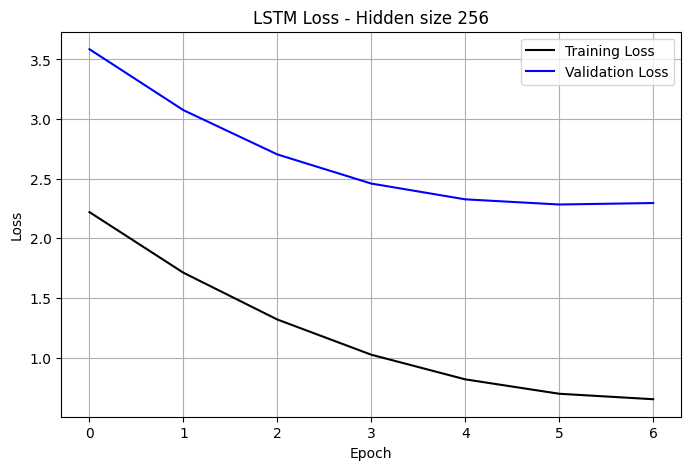

In [8]:
hidden_size = 256  # choose which model to plot
train_losses = np.load(f"stateful_models/train_losses_h{hidden_size}.npy", allow_pickle=True)
val_losses = np.load(f"stateful_models/val_losses_h{hidden_size}.npy", allow_pickle=True)

plt.figure(figsize=(8,5))
plt.plot(train_losses, color='black', label='Training Loss')
plt.plot(val_losses, color='blue', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'LSTM Loss - Hidden size {hidden_size}')
plt.grid(True)
plt.legend()
plt.show()


### Evaluation

torch.float64


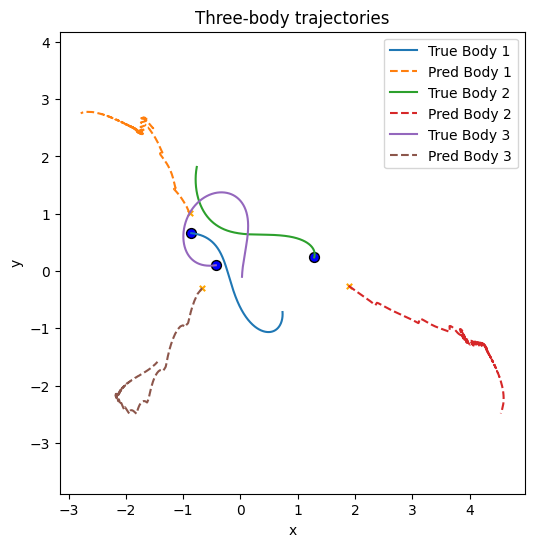

In [33]:
initialization_steps = 1000
steps = 5000
hidden_size = 512  # must match the checkpoint you're loading

model = LSTM(
    input_size=12,
    hidden_size=hidden_size,
    output_size=12,
    initializer_method='xavier'
).to(device)

model.load_state_dict(torch.load(f"stateful_models/lstm_stateful_h{hidden_size}.pt"))
model.eval()

print(next(model.parameters()).dtype)
model = model.float()

output = model.generate_timeseries(X_test[:initialization_steps].to(device), steps=steps)
y_test = y_test.float()
true = y_test[initialization_steps:steps]

# Convert back to original scale
true_np = scaler.inverse_transform(true.detach().numpy())
output_np = scaler.inverse_transform(output.detach().numpy())

plot_trajectories(true_np, output_np)


In [ ]:
initialization_steps = 1000
steps = 5000
pred_steps = steps - initialization_steps
hidden_size = 1024  # must match the checkpoint you're loading

model = LSTM(
    input_size=12,
    hidden_size=hidden_size,
    output_size=12,
    initializer_method='xavier'
).to(device)

model.load_state_dict(torch.load(f"stateful_models/lstm_stateful_h{hidden_size}.pt"))
model.eval()
model = model.float()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score

def validate_test_data(model, X_test, y_test, criterion, device="cpu"):
    model.eval()

    losses = []
    r2_scores = []
    test_preds = []

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        for i in range(len(X_test_tensor)):

            x = X_test_tensor[i].unsqueeze(0)  # (1, seq_len, features)
            y_true = y_test_tensor[i].unsqueeze(0)

            y_pred_seq, _ = model.forward(x)  # (seq_len, output_dim)
            print(y_pred_seq.dtype)
            
            y_pred = y_pred_seq[-1, :].unsqueeze(0)  # (1, output_dim)

            test_preds.append(y_pred.cpu().numpy().flatten())

            loss = criterion(y_pred, y_true).item()
            losses.append(loss)

            r2 = r2_score(y_true.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())
            r2_scores.append(r2)

    print(f"Average MSE (non-autoregressive): {np.mean(losses):.4f}")
    print(f"Average R2  (non-autoregressive): {np.mean(r2_scores):.4f}")

    return np.array(test_preds)


Average MSE (non-autoregressive): 0.5530
Average R2  (non-autoregressive): 0.1561


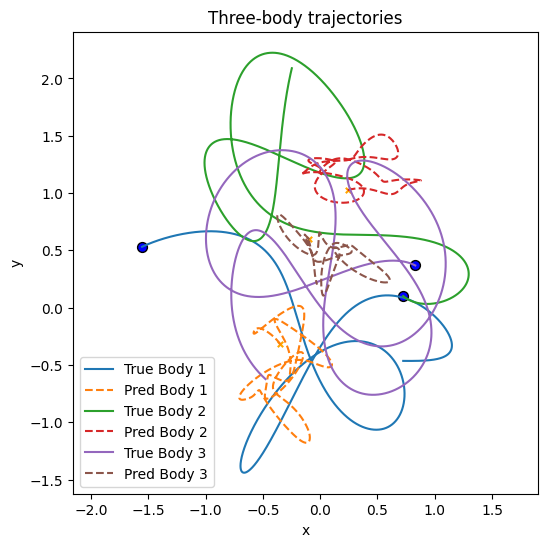

In [24]:
import torch.nn as nn

criterion = nn.MSELoss()

test_preds = validate_test_data(model, X_test.numpy(), y_test.numpy(), criterion, device=device)

# invert scaling
test_preds_scaled = scaler.inverse_transform(test_preds)
y_test_scaled = scaler.inverse_transform(y_test.numpy())

plot_trajectories(y_test_scaled, test_preds_scaled)